In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])

# Train the initial Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1729)
rf.fit(initial_points, initial_values)

# Active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 0.1
improvement = []



In [3]:
# Perform active learning with adaptive sampling
min_function_values = [np.min(initial_values)]  # Track min function value for each iteration
samples = initial_points
sample_values = initial_values

In [4]:
for iteration in range(num_iterations):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=20)
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Calculate the distance of each new candidate point to the existing points
    distances_to_existing = np.array([[min([euclidean_distance(new_point, sample) for sample in samples]) for new_point in new_points]])

    # Normalize distances to obtain scores between 0 and 1
    max_distance = np.max(distances_to_existing)
    scores = 1 - distances_to_existing / max_distance

    # Find the index of the point with the maximum score
    index_of_max_score = np.argmin(scores)

    # The point with the maximum score
    chosen_new_point = new_points[index_of_max_score]

    # Update the model with the new point
    chosen_new_value = np.array([eggholder_function(chosen_new_point[0], chosen_new_point[1])])

    # Update training data
    new_points_all = np.vstack([samples, chosen_new_point])
    new_values_all = np.append(sample_values, chosen_new_value)

    # Sort the values in descending order
    new_values_all.sort()

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(np.hstack((initial_values, new_values_all))))

    # Re-fit the model including the new points
    rf.fit(new_points_all, new_values_all)

    # Calculate improvement
    rmse = (mean_squared_error(new_values_all, rf.predict(new_points_all)))**0.5
    improvement.append(rmse)

    print(f"Iteration {iteration+1}, RMSE: {rmse}")

    # Check for convergence (change in func value less than the tolerance)
    if len(improvement) > 1 and abs(improvement[-2]-improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration+1}.")
        break

    # Update the sample points and values for the next iteration
    samples = new_points_all
    sample_values = new_values_all

Iteration 1, RMSE: 131.8907969031064
Iteration 2, RMSE: 137.23465356208285
Iteration 3, RMSE: 157.7620591090396
Iteration 4, RMSE: 192.28243353884923
Iteration 5, RMSE: 177.28442614815827
Iteration 6, RMSE: 176.1912829817929
Iteration 7, RMSE: 183.25657690960904
Iteration 8, RMSE: 183.06825879300553
Iteration 9, RMSE: 166.5300046230173
Iteration 10, RMSE: 150.38749684020536
Iteration 11, RMSE: 155.9508677797025
Iteration 12, RMSE: 136.42726625901892
Iteration 13, RMSE: 161.54978276171084
Iteration 14, RMSE: 151.9522011297106
Iteration 15, RMSE: 157.4761277946581
Iteration 16, RMSE: 159.55735744277703
Iteration 17, RMSE: 152.18563747473013
Iteration 18, RMSE: 146.20555862094173
Iteration 19, RMSE: 137.17613733055768
Iteration 20, RMSE: 142.54096130946732
Iteration 21, RMSE: 168.98731839577997
Iteration 22, RMSE: 164.1176732240673
Iteration 23, RMSE: 173.4621140731773
Iteration 24, RMSE: 152.2307210477836
Iteration 25, RMSE: 157.84698493695583
Iteration 26, RMSE: 163.00995047434512
Itera

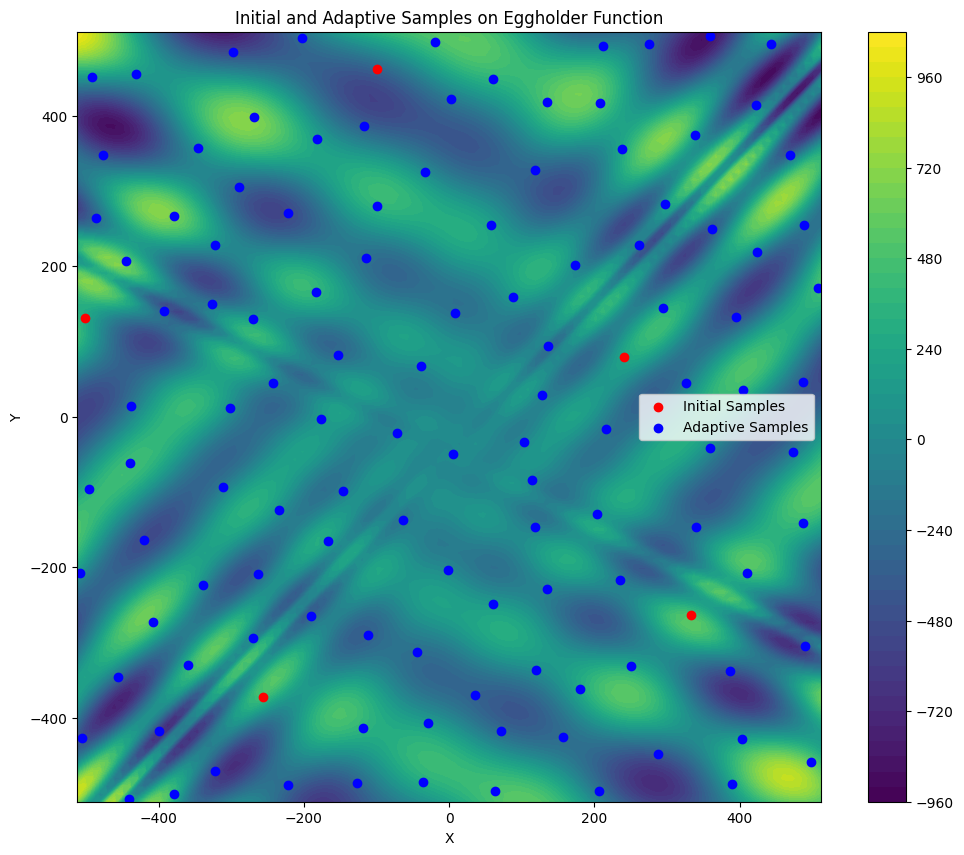

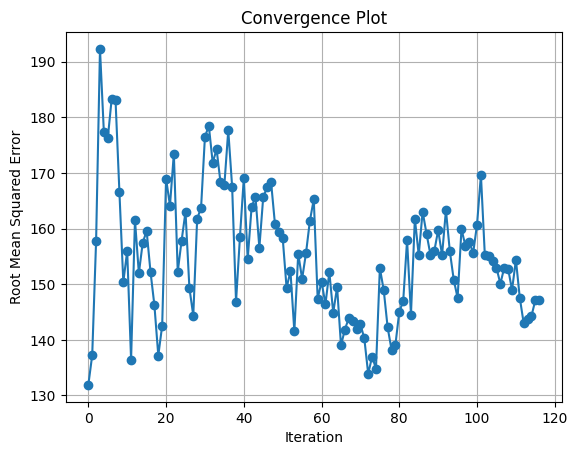

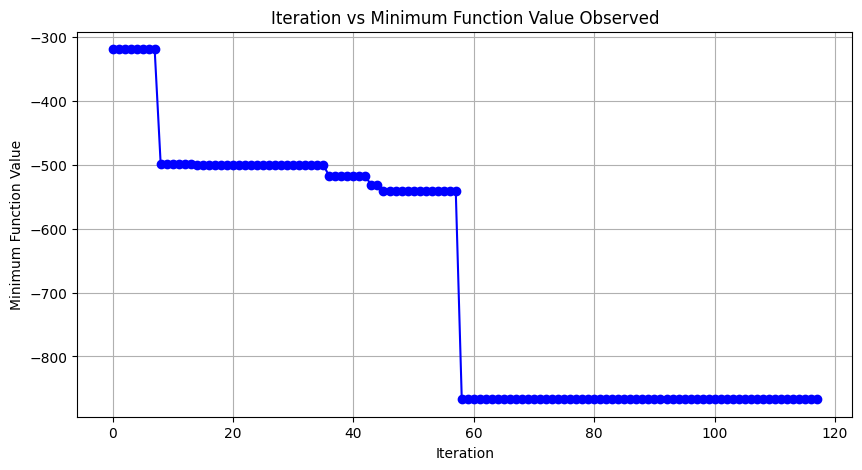

Best observed function value after active learning: -867.067395944965
             X1          X2
0   -256.573634 -372.845535
1    333.146745 -264.206358
2    -99.935209  461.849713
3   -500.514973  131.020497
4    240.222072   79.717149
..          ...         ...
117  422.274096  414.914782
118  297.347156  283.210037
119  403.977070   35.561669
120  423.836991  218.532637
121 -117.408994  386.395701

[122 rows x 2 columns]


In [5]:
# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:,0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(new_points_all[5:, 0], new_points_all[5:, 1], c='blue', label='Adaptive Samples')
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()

# Print final result
print(f"Best observed function value after active learning: {min(min_function_values)}")

# Save the final samples to a DataFrame
samples_df = pd.DataFrame({"X1": new_points_all[:,0], "X2": new_points_all[:,1]})
print(samples_df)